In [1]:
!pip3 install -U scikit-fuzzy

In [1]:
import random
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [2]:
# the simulated price table
# VCPU 
# 0-10: 0.2€/st 1 month
# 11-30: 0.1
# 31-90: 0.05
# RAM 
# 0-20: 0.1€/per GB month
# 21-60: 0.05
# 61-180: 0.025
# VOLUME：
# 0-100：0.02€/per GB 1 month
# 101-300：0.01€/per GB 1 month
# 301-900：0.005€/per GB 1 month

In [3]:
def visualize_parameter(x_range,y_range,requirement,ylabel):
    plt.figure(figsize=[15, 5])
    x = x_range
    y = y_range
    x_diff = x_range[-1] - x_range[0]
    plt.xlim((x_range[0]-0.1*x_diff, x_range[-1]+0.1*x_diff))
    l1 = plt.plot(x, y, color='b',marker='o',linestyle='dashed',label='Provider proposal')
    #plt.axis([-5, x_range[-1]+5, requirement-10,  y_range[0]+10])
    plt.xlabel('round')
    plt.ylabel(ylabel)
    y_requirement = [requirement]*len(x_range)
    l2 = plt.plot(x, y_requirement, color='r',linestyle='dashed',label='Client requirement')
    plt.annotate('Last offer', xy=(x_range[-1],y_range[-1]), xytext=(x_range[-1],y_range[-1]-(y_range[0]-y_range[-1])*0.2),
            arrowprops=dict(facecolor='black',width=0.5, headwidth=7, shrink=0.005),
            )
    plt.legend()
    plt.show()

In [4]:
# Class for provider
class provider_base:
    min_change = [1, 1, 10]
    # input the initial number of vcpu,ram,volume
    def __init__(self, n_vcpu0 = 0, n_ram0 = 0, n_volume0 = 0):
        self.n_vcpu0 = n_vcpu0
        self.n_ram0 = n_ram0
        self.n_volume0 = n_volume0
        
    # Functions for controlling the value range of issues
    def vcpu_range(self,n):
        n_initial = 0
        if 0 < n <= 10:
            n_initial = 10+n
        elif 11 <= n <= 30:
            n_initial = 30+n
        elif 31 <= n <= 90:
            n_initial = n
        else:
            print('Out of Range!')
            return -1
        return n_initial

    def ram_range(self,n):
        n_initial = 0
        if 0 < n <= 20:
            n_initial = 20+n
        elif 21 <= n <= 60:
            n_initial = 60+n
        elif 61 <= n <= 180:
            n_initial = n
        else:
            print('Out of Range!')
            return -1
        return n_initial

    def volume_range(self,n):
        n_initial = 0
        if 0 < n <= 100:
            n_initial = 100+n
        elif 101 <= n <= 300:
            n_initial = 300+n
        elif 301 <= n <= 900:
            n_initial = n
        else:
            print('Out of Range!')
            return -1
        return n_initial

    def initial_offer(self,client_requirement):
        n_vcpu0 = self.vcpu_range(client_requirement[0])
        n_ram0 = self.ram_range(client_requirement[1])
        n_volume0 = self.volume_range(client_requirement[2])
        return n_vcpu0,n_ram0,n_volume0
    
    def compute_ratio(self,client_requirement):
        ratio = [int(i/client_requirement[0]) for i in client_requirement]
        times1round_vcpu = int(ratio[0]/provider_base.min_change[0])
        times1round_ram = int(ratio[1]/provider_base.min_change[1])
        times1round_volume = int(ratio[2]/provider_base.min_change[2])
        times1round = times1round_vcpu+times1round_ram+times1round_volume
        
        return times1round_vcpu,times1round_ram,times1round_volume,times1round
               
    def update_offer(self,times1round_vcpu,times1round_ram,times1round_volume,times1round,
                     n_vcpu0,n_ram0,n_volume0,
                     client_requirement,client_advice):
        if client_advice == 'random':
            # like random gradient decent
            rand_int = random.randint(1,times1round)
            t1 = times1round_vcpu
            t2 = t1+times1round_ram
            t3 = t2+times1round_volume

            if 1<=rand_int<=t1:
                if n_vcpu0 > client_requirement[0]:
                    n_vcpu0=n_vcpu0-provider_base.min_change[0]
                elif n_ram0 > client_requirement[1]:
                    n_ram0=n_ram0-provider_base.min_change[1]
                elif n_volume0 > client_requirement[2]:
                    n_volume0=n_volume0-provider_base.min_change[2]

            elif t1+1<=rand_int<=t2:
                if n_ram0 > client_requirement[1]:
                    n_ram0=n_ram0-provider_base.min_change[1]
                elif n_volumcjj19e0 > client_requirement[2]:
                    n_volume0=n_volume0-provider_base.min_change[2]
                elif n_vcpu0 > client_requirement[0]:
                    n_vcpu0=n_vcpu0-provider_base.min_change[0]

            elif t2+1<=rand_int<=t3:
                if n_volume0 > client_requirement[2]:
                    n_volume0=n_volume0-provider_base.min_change[2]
                elif n_vcpu0 > client_requirement[0]:
                    n_vcpu0=n_vcpu0-provider_base.min_change[0]
                elif n_ram0 > client_requirement[1]:
                    n_ram0=n_ram0-provider_base.min_change[1]
        else:
            if client_advice == 'vcpu':
                n_vcpu0=n_vcpu0-provider_base.min_change[0]
                #print('reduce vcpu')
            elif client_advice == 'ram':
                n_ram0=n_ram0-provider_base.min_change[1]
                #print('reduce ram')
            elif client_advice == 'volume':
                n_volume0=n_volume0-provider_base.min_change[2]
                #print('reduce volume')
            else:
                print('Wrong!')
                return -1
            
        return n_vcpu0,n_ram0,n_volume0        

In [5]:
# Class for client
class client_base:
    def __init__(self, client_requirement):
        self.requirement = client_requirement
              
    def compute_fee(self, p1, p2, p3, t1, t2, n):
        fee = 0
        if 0 < n <= t1:
            fee = p1*n
        elif t1 < n <= t2:
            fee = p1*t1+p2*(n-t1)
        elif t2 < n :
            fee = p1*t1+p2*(t2-t1)+p3*(n-t2)
        else:
            print('Out of Range!')
            return -1
        return fee
    
    def compute_avg_price(self, fee, num):
        return fee/num
    
    def compute_total_fee(self, f1, f2, f3):
        return f1+f2+f3
    
    def scale2one_avg(self, obj, old, new):
        ratio = new/old
        # the avg price ratio
        # new/old: the cheaper, the better
        # ratio: close to 0 is better, close to 1 is worse
        if obj == 'avg':
            return ratio
        # the total fee ratio
        # new total fee is always larger than old total fee
        # ratio is larger than 1, the larger the worse
        # the reciproval is between o and 1. the closer to 0, the worse
        # the closer to 1, the better
        elif obj == 'total':
            return 1/ratio
    
    def related_fee(self, client_requirement = None):
        
        if client_requirement == None:
            client_requirement = self.requirement
            
        vcpu_fee_r = self.compute_fee(0.2,0.1,0.05,10,30,client_requirement[0])
        vcpu_avg_r = self.compute_avg_price(vcpu_fee_r,client_requirement[0])
        ram_fee_r = self.compute_fee(0.1,0.05,0.025,20,60,client_requirement[1])
        ram_avg_r = self.compute_avg_price(ram_fee_r,client_requirement[1])
        volume_fee_r = self.compute_fee(0.02,0.01,0.005,100,300,client_requirement[2])
        volume_avg_r = self.compute_avg_price(volume_fee_r,client_requirement[2])
        total_fee_r = vcpu_fee_r+ram_fee_r+volume_fee_r
        return vcpu_avg_r,ram_avg_r,volume_avg_r,total_fee_r
    
    def fuzzy_decision(self):
        # Fuzzy logic

        # New Antecedent/Consequent objects hold universe variables and membership functions
        avg_vcpu = ctrl.Antecedent(np.arange(0, 11, 0.001), 'avg_vcpu')
        avg_ram = ctrl.Antecedent(np.arange(0, 11, 0.001), 'avg_ram')
        avg_volume = ctrl.Antecedent(np.arange(0, 11, 0.001), 'avg_volume')
        total_fee = ctrl.Antecedent(np.arange(0, 11, 0.001), 'total_fee')

        tendency = ctrl.Consequent(np.arange(0, 101, 0.01), 'tendency')

        # Auto-membership function population is possible with .automf(3, 5, or 7)
        # poor average good, automatically
        names_avg = ['cheap','medium','expensive']
        avg_vcpu.automf(names = names_avg)
        avg_ram.automf(names = names_avg)
        avg_volume.automf(names = names_avg)

        names_total = ['high','medium','low']
        total_fee.automf(names = names_total)

        # Custom membership functions can be built interactively with a familiar,
        # Pythonic API
        tendency['low'] = fuzz.trimf(tendency.universe, [0, 0, 50])
        tendency['medium'] = fuzz.trimf(tendency.universe, [0, 50, 100])
        tendency['high'] = fuzz.trimf(tendency.universe, [50, 100, 100])
        
        # Rules
        rule1 = ctrl.Rule(total_fee['high'], tendency['low'])
        rule2 = ctrl.Rule(total_fee['medium'], tendency['medium'])
        rule3 = ctrl.Rule(total_fee['low'], tendency['high'])
        rule4 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['cheap']&avg_ram['cheap'], tendency['high'])
        rule5 = ctrl.Rule(avg_vcpu['expensive'], tendency['medium'])
        rule6 = ctrl.Rule(avg_ram['expensive'], tendency['medium'])
        rule7 = ctrl.Rule(avg_volume['expensive'], tendency['medium'])
        
        # Fuzzy decision simulation
        decision_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])
        decision = ctrl.ControlSystemSimulation(decision_ctrl)
        
        return decision
    
    def advice(self, offer, client_requirement, threshold):
        # we would like to keep the original ratio
        # if the offer ratio is the same as the requirement
        # the following ratio should be the same
        vcpu_ratio = offer[0]/client_requirement[0]
        ram_ratio = offer[1]/client_requirement[1]
        volume_ratio = offer[2]/client_requirement[2]
        ratio_dict ={'vcpu':vcpu_ratio, 'ram':ram_ratio, 'volume':volume_ratio}
        max_item = max(ratio_dict, key=ratio_dict.get)
        min_item = min(ratio_dict, key=ratio_dict.get)
        difference_ratio = ratio_dict[max_item]/ratio_dict[min_item]
        if difference_ratio > threshold:
            return max_item
        else:
            return 'random'

# The simulated price table
## VCPU 
0-10: 0.2€/st 1 day  
11-30: 0.1  
31-90: 0.05  
## RAM 
0-20: 0.1€/per GB day  
21-60: 0.05  
61-180: 0.025  
## VOLUME：
0-100：0.02€/per GB 1 day  
101-300：0.01€/per GB 1 day  
301-900：0.005€/per GB 1 day  

In [6]:
# Negotiation

# order: CPU-st, RAM-GB, VOLUME-GB
# client_requirement = [15, 30, 225] 
def negotiation_client_advice(client_requirement):
    
    # Client
    client = client_base(client_requirement)
    client_decision = client.fuzzy_decision()
    # Provider
    provider = provider_base()
    offer = provider.initial_offer(client_requirement)
    times1round_vcpu,times1round_ram,times1round_volume,times1round = provider.compute_ratio(client_requirement)

    # Original price, i.e. baseline
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old = client.related_fee()
    #print('*********************************************************************')
    #print('Client requirement: ', client_requirement)
    #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_old,ram_avg_old,volume_avg_old))
    #print('total_fee: %f'%total_fee_old)
    #print('*********************************************************************')
    # For plotting
    steps = [];vcpu = [];ram = [];volume = [];avg_vcpu = [];avg_ram = [];avg_volume = [];total_fee = []
    #print('Provider first offer: ',offer)
    max_rounds = 120
    i = 0;
    while True:
        steps.append(i)
        vcpu.append(offer[0])
        ram.append(offer[1])
        volume.append(offer[2])
        # New fees
        vcpu_avg_new,ram_avg_new,volume_avg_new,total_fee_new = client.related_fee(offer)
        avg_vcpu.append(vcpu_avg_new);avg_ram.append(ram_avg_new);avg_volume.append(volume_avg_new);total_fee.append(total_fee_new)
        # input of fuzzy system
        input_avg_vcpu = 10*client.scale2one_avg('avg', vcpu_avg_old, vcpu_avg_new)
        input_avg_ram = 10*client.scale2one_avg('avg', ram_avg_old, ram_avg_new)
        input_avg_volume = 10*client.scale2one_avg('avg', volume_avg_old, volume_avg_new)
        input_total_fee = 10*client.scale2one_avg('total', total_fee_old, total_fee_new)
        dict_of_data = {'avg_vcpu':input_avg_vcpu,'avg_ram':input_avg_ram,'avg_volume':input_avg_volume,'total_fee':input_total_fee}
        #dict_of_data = {'avg_vcpu':5,'avg_ram':5,'avg_volume':5,'total_fee':2}
        #print(dict_of_data)

        # Client makes decision
        client_decision.inputs(dict_of_data)
        # Crunch the numbers
        client_decision.compute()
        decision_score = client_decision.output['tendency']
        #print('---------------------------------------------------------------')
        #print('offer %d: '%i , offer, ' its score: ',decision_score)
        #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_new,ram_avg_new,volume_avg_new))
        #print('total_fee: %f'%total_fee_new)
        #print('---------------------------------------------------------------')

        # if accepet
        if decision_score >= 55:
            final_offer = offer
            #print('-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-')
            #print('This final offer is ',final_offer)
            #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_new,ram_avg_new,volume_avg_new))
            #print('total_fee: %f'%total_fee_new)
            #print('-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-')
            break
        # if reject  
        else:
            if offer[0]>client_requirement[0] or offer[1]>client_requirement[1] or offer[2]>client_requirement[2]:
                client_advice = client.advice(offer,client_requirement,1.05)
                #print('client advice: ',client_advice)
                #print('           ')
                offer = provider.update_offer(times1round_vcpu,times1round_ram,times1round_volume,times1round,
                                              offer[0],offer[1],offer[2],
                                             client_requirement,client_advice)
                #print(offer)
            else:
                final_offer = offer
                #print('Round:',i,'break!')
                #print('Last offer: ' , offer, ' its score: ',decision_score)
                #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_new,ram_avg_new,volume_avg_new))
                #print('total_fee: %f'%total_fee_new) 
                break
        i = i+1
        if i > max_rounds:
            final_offer = offer
            #print('Round %d'%i,' . Reach the MAX round!')
            #print('Last offer: ' , offer, ' its score: ',decision_score)
            #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_new,ram_avg_new,volume_avg_new))
            #print('total_fee: %f'%total_fee_new)       
            break
    return steps,vcpu,ram,volume,vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,avg_vcpu,avg_ram,avg_volume,total_fee,final_offer


# Generate test data set

In [7]:
random.seed(19260817)
x_test = pd.read_csv('./data/offer_ML/x_test_200_v1.csv',index_col=0).reset_index(drop=True)

In [8]:
test_final_offer_list = []
for index,row in tqdm(x_test.iterrows(),total=x_test.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    test_final_offer_list.append(final_offer_dict)
y_test = pd.DataFrame(test_final_offer_list)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:12<00:00,  2.75it/s]


In [9]:
y_test

,final_vcpu,final_ram,final_volume
0,8,43,400
1,9,44,280
2,12,92,400
3,11,96,320
4,12,102,520
...,...,...,...
195,47,122,660
196,47,138,700
197,47,164,720
198,48,111,820


In [10]:
x_test

,vcpu,ram,volume
0,5,25,400
1,7,35,220
2,7,54,400
3,7,56,320
4,7,56,520
...,...,...,...
195,47,122,660
196,47,138,700
197,47,164,720
198,48,111,820


In [11]:
y_test.to_csv('./data/offer_ML/v1_y_test_200_v1.csv')

## Train size = 10000

In [7]:
x_train_104 = pd.read_csv('./data/offer_ML/x_train_104_v1.csv',index_col=0).reset_index(drop=True)

In [8]:
train_final_offer_list = []
for index,row in tqdm(x_train_104.iterrows(),total=x_train_104.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    train_final_offer_list.append(final_offer_dict)
y_train_104 = pd.DataFrame(train_final_offer_list)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [1:06:24<00:00,  2.51it/s]


In [9]:
y_train_104.to_csv('./data/offer_ML/v1_y_train_104_v1.csv')

# Single test

In [7]:
random.seed(19260817)
vcpu = 10
ram = 20
volume = 200  
client_requirement = [vcpu, ram, volume]
time_start=time.time()
steps,vcpu,ram,volume,\
vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
avg_vcpu,avg_ram,avg_volume,total_fee,\
final_offer = negotiation_client_advice(client_requirement)
time_end=time.time()
print('time cost',time_end-time_start,'s')

time cost 1.1569054126739502 s


In [8]:
len(steps)

42

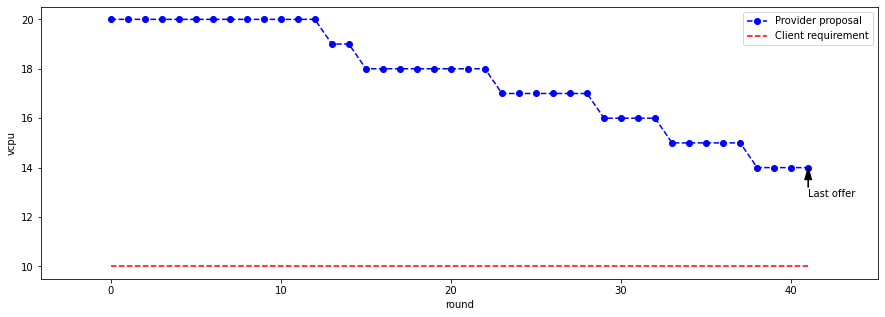

In [89]:
visualize_parameter(steps,vcpu,client_requirement[0],'vcpu')

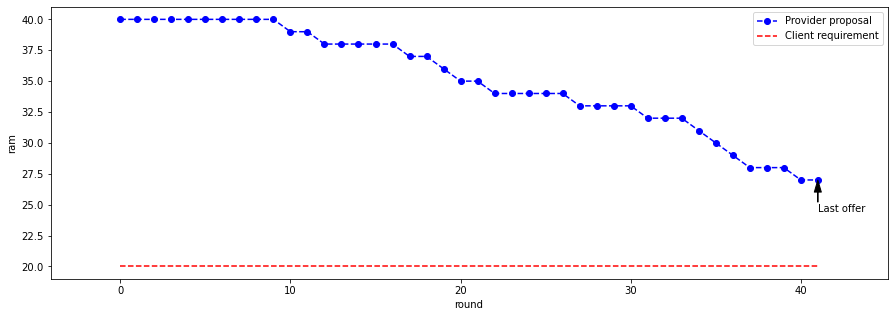

In [88]:
visualize_parameter(steps,ram,client_requirement[1],'ram')

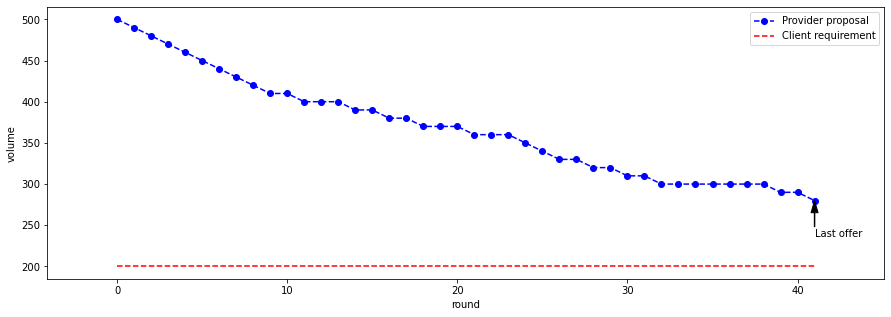

In [87]:
visualize_parameter(steps,volume,client_requirement[2],'volume')